In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [90]:
dir_path = 'TrainingData'
imu = pd.DataFrame()
imu_time = pd.DataFrame()
y = pd.DataFrame()
y_time = pd.DataFrame()
for f in sorted(os.listdir(dir_path)):
        if f[-7:] == '__x.csv':
            csv_data = pd.read_csv(f'{dir_path}/{f}',
                        header=None,
                        names =['x_accel','y_accel','z_accel','x_gyro','y_gyro','z_gyro'],
                        dtype=np.float64)
            sub = f[-13:-10]
            sub = int(sub)
            trial_val = f[-9:-7]
            trial_val = int(trial_val)
            csv_data = csv_data.assign(subject = sub)
            csv_data = csv_data.assign(trial = trial_val)
            imu = pd.concat([imu, csv_data], axis=0)

        elif f[-12:] == '__x_time.csv':
            csv_data = pd.read_csv(f'{dir_path}/{f}',
                        header=None,
                        names =['x_time'],
                        dtype=np.float64)
            sub = f[-18:-15]
            sub = int(sub)
            csv_data = csv_data.assign(subject = sub)
            imu_time = pd.concat([imu_time, csv_data], axis=0)

        elif f[-7:] == '__y.csv':
            csv_data = pd.read_csv(f'{dir_path}/{f}',
                        header=None,
                        names =['y'],
                        dtype=np.int8)
            sub = f[-13:-10]
            sub = int(sub)
            trial_val = f[-9:-7]
            trial_val = int(trial_val)
            csv_data = csv_data.assign(subject = sub)
            csv_data = csv_data.assign(trial = trial_val)
            y = pd.concat([y, csv_data], axis=0)

        elif f[-12:] == '__y_time.csv':
            csv_data = pd.read_csv(f'{dir_path}/{f}',
                        header=None,
                        names =['y_time'],
                        dtype=np.float64)
            sub = f[-18:-15]
            sub = int(sub)
            csv_data = csv_data.assign(subject = sub)
            y_time = pd.concat([y_time, csv_data], axis=0)
            
imu_data = pd.concat([imu,imu_time['x_time']], axis=1)
y_data = pd.concat([y,y_time['y_time']],axis = 1)
#print(imu_data.head())
print(y_data.head())

   y  subject  trial  y_time
0  0        1      1    0.02
1  0        1      1    0.12
2  0        1      1    0.22
3  0        1      1    0.32
4  0        1      1    0.42


"\ndata.at[0,'y'] = 1\nprint(data.head())\nfor i in range(0,len(y_data['y'])):\n     y = y_data['y'].iloc[i]\n     data.at[4*i,'y'] = y\n     data.at[4*i+1,'y'] = y\n     data.at[4*i+2,'y'] = y\n     data.at[4*i+3,'y'] = y\n"

In [107]:
# upsamples from 10Hz to 40 Hz
y_10 = y_data['y'].to_numpy()
y_40 = np.array([]) 

for i in range(0,len(y_10)):
     y_40 = np.append(y_40, [y_10[i],y_10[i],y_10[i],y_10[i]])


print((y_40.shape))


(1341652,)


In [108]:
# removes the last 6 elements so the sizes match. dont run more than once. Maybe use reshape? or view instead?
y_40 = np.delete(y_40,[-6,-5,-4,-3,-2,-1])
print(imu_data.shape)
print(y_40.shape)
data = imu_data
data['y_new'] = y_40.tolist()
data.head()

(1341646, 9)
(1341646,)


,x_accel,y_accel,z_accel,x_gyro,y_gyro,z_gyro,subject,trial,x_time,y_new
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,1,1,0.000,0.0
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,1,1,0.025,0.0
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,1,1,0.050,0.0
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,1,1,0.075,0.0
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,1,1,0.100,0.0


In [111]:
data.dropna(axis=0, how='any', inplace=True)
print(data.head())
print(data.shape)

    x_accel   y_accel   z_accel    x_gyro    y_gyro    z_gyro  subject  trial   
0  4.435275  8.196063  2.974488  0.014215 -0.039157 -0.016744        1      1  \
1  4.186920  8.344455  2.908057  0.005771 -0.004480 -0.003345        1      1   
2  4.544637  8.408659  2.890000  0.007967  0.022412  0.001159        1      1   
3  4.849308  8.411614  2.900692  0.027778 -0.010670 -0.014223        1      1   
4  4.509190  8.118649  2.847298  0.021577 -0.045498 -0.021111        1      1   

   x_time  y_new  
0   0.000    0.0  
1   0.025    0.0  
2   0.050    0.0  
3   0.075    0.0  
4   0.100    0.0  
(1341646, 10)


In [112]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_accel', 'y_accel', 'z_accel','x_gyro','y_gyro','z_gyro']

scaler = RobustScaler()

scaler = scaler.fit(data[scale_columns])

data.loc[:, scale_columns] = scaler.transform(data[scale_columns].to_numpy())
#df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [115]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    data[scale_columns], 
    data['y_new'], 
    TIME_STEPS, 
    STEP
)

/var/folders/m_/421bzb5d0h92ss631nbbk9ym0000gn/T/ipykernel_7806/1542748167.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])


In [116]:
print(X_train.shape, y_train.shape)

(33537, 200, 6) (33537, 1)


In [117]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
#y_test = enc.transform(y_test)

/Users/javert/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [118]:
print(X_train.shape, y_train.shape)

(33537, 200, 6) (33537, 4)


In [119]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [120]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split = 0.2,
    shuffle=False
)

Epoch 1/20


2023-04-15 20:07:23.879139: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


420/420 [==============================] - 67s 157ms/step - loss: 0.7134 - acc: 0.7451 - val_loss: 0.6590 - val_acc: 0.7342
Epoch 2/20
420/420 [==============================] - 62s 148ms/step - loss: 0.6038 - acc: 0.7628 - val_loss: 0.6356 - val_acc: 0.7324
Epoch 3/20
420/420 [==============================] - 62s 147ms/step - loss: 0.5969 - acc: 0.7702 - val_loss: 0.6674 - val_acc: 0.7506
Epoch 4/20
420/420 [==============================] - 59s 140ms/step - loss: 0.5696 - acc: 0.7786 - val_loss: 0.6275 - val_acc: 0.7382
Epoch 5/20
420/420 [==============================] - 60s 142ms/step - loss: 0.5988 - acc: 0.7795 - val_loss: 0.5865 - val_acc: 0.7488
Epoch 6/20
420/420 [==============================] - 60s 142ms/step - loss: 0.5270 - acc: 0.7906 - val_loss: 0.6074 - val_acc: 0.7554
Epoch 7/20
420/420 [==============================] - 57s 136ms/step - loss: 0.5843 - acc: 0.7806 - val_loss: 0.5881 - val_acc: 0.7616
Epoch 8/20
420/420 [==============================] - 60s 142ms/st

In [124]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


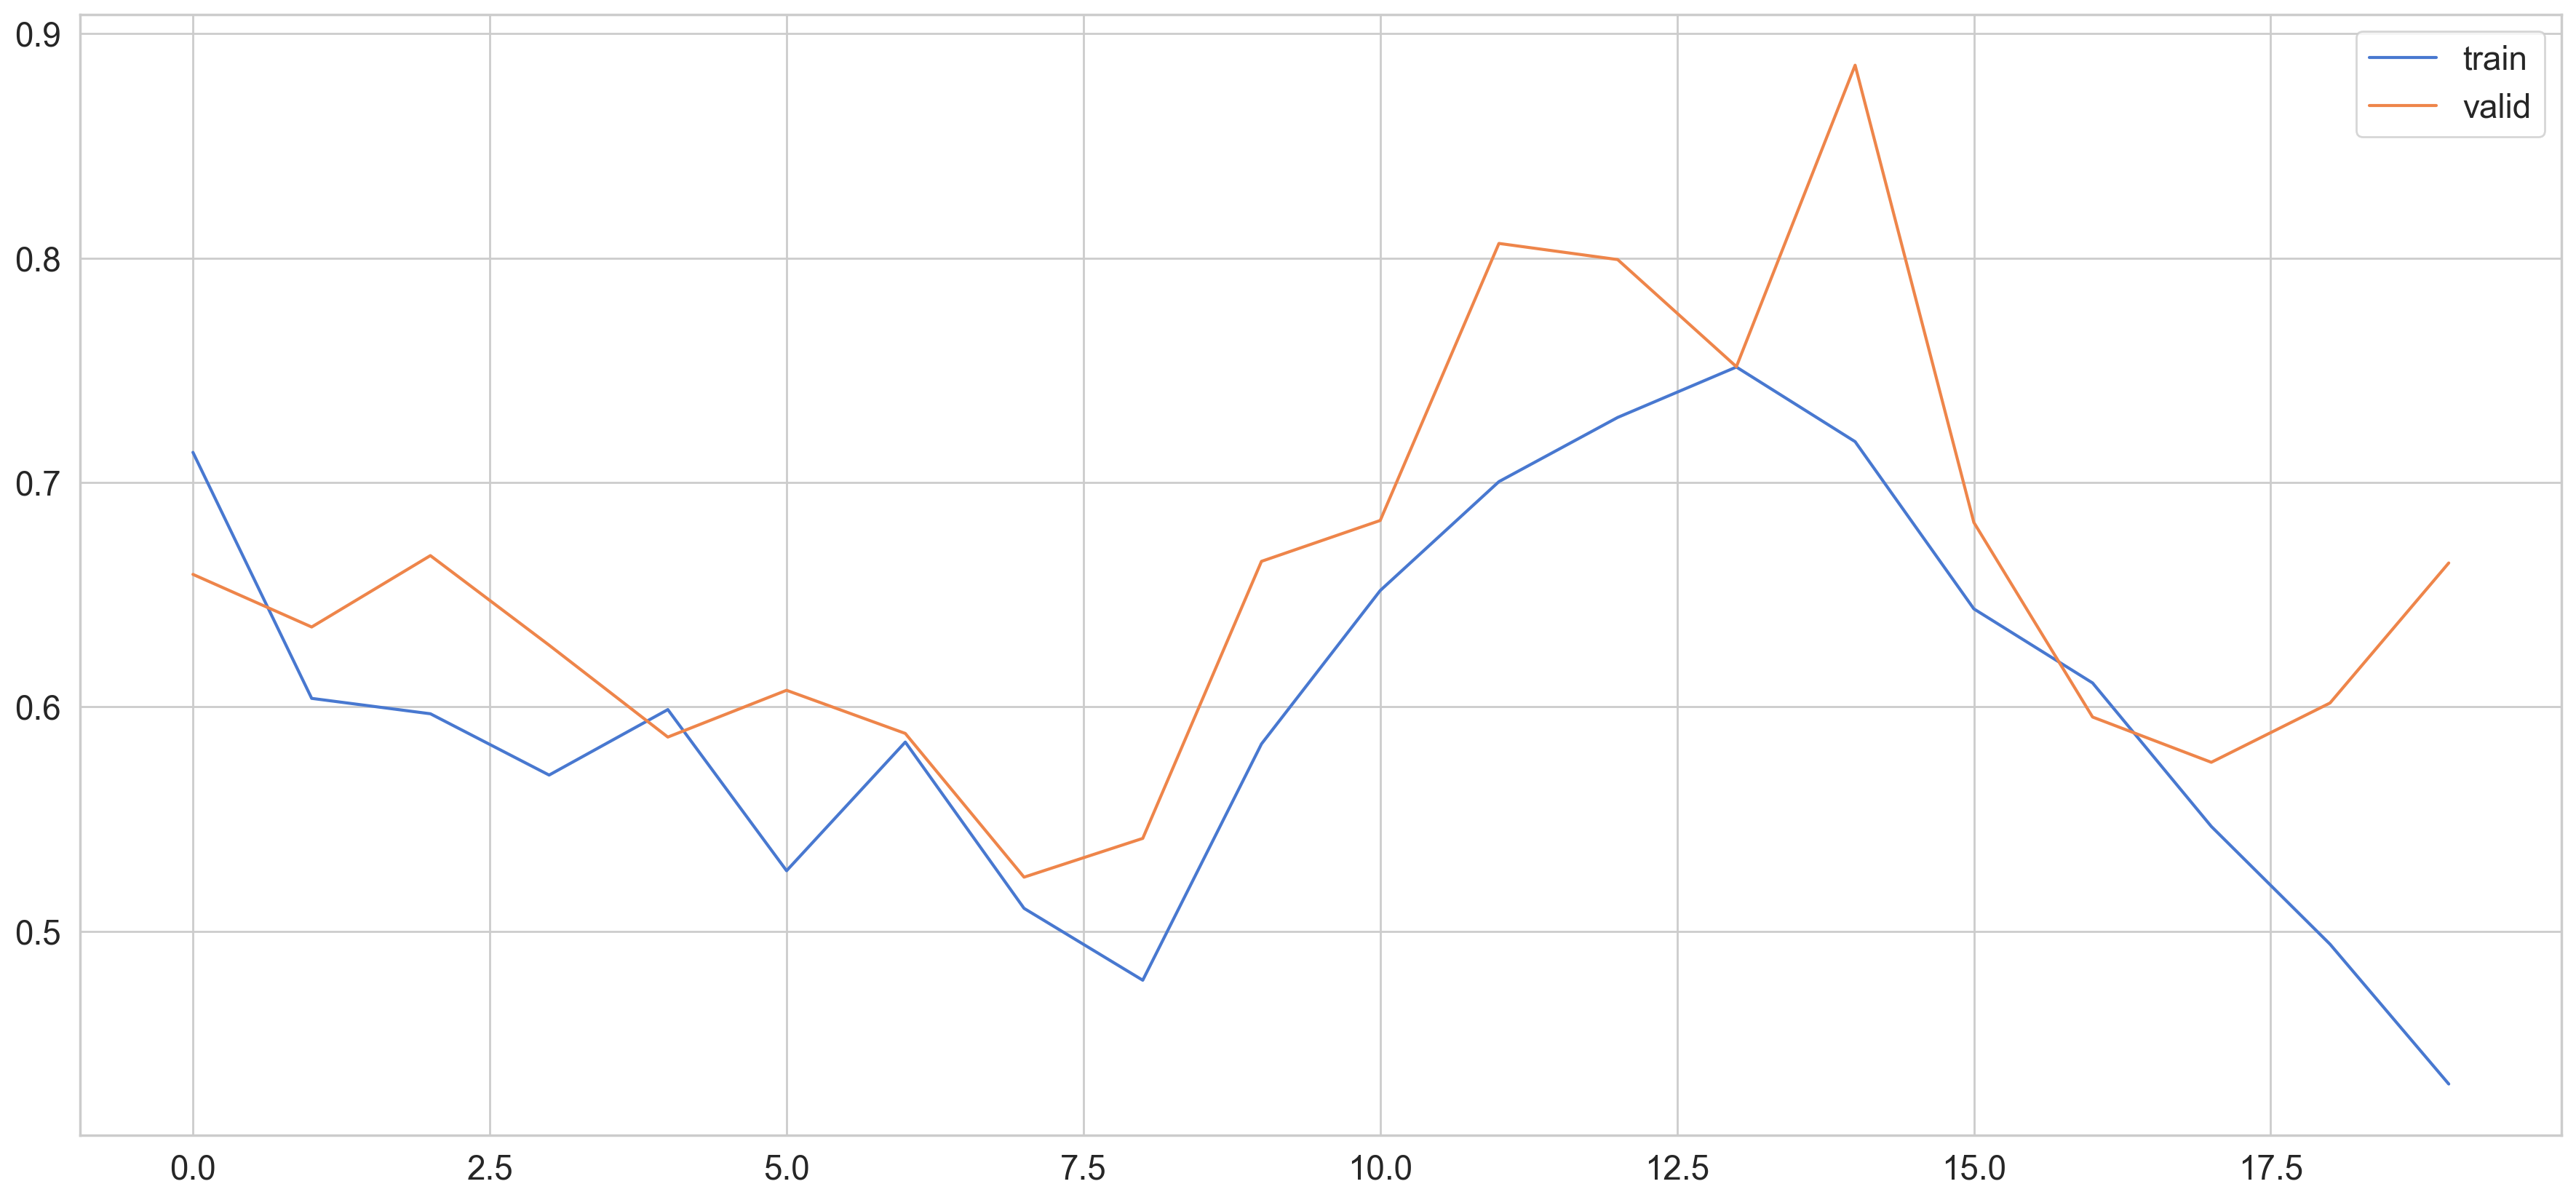

In [122]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_pred = model.predict(X_test)

In [123]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

In [ ]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)